In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

root_logs = os.path.join('logs', 'callbacks')
os.makedirs(root_logs)

In [2]:
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Get the data

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full, x_test = x_train_full/255., x_test/255.

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full)

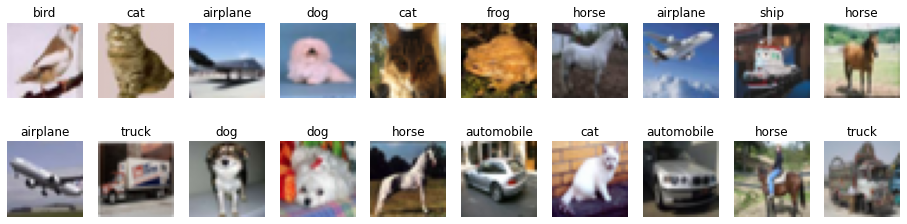

In [5]:
from utils import display_gallery

labels_map = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck'])
display_gallery(x_train[:20], labels_map[y_train[:,0]])

In [6]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv2D, MaxPooling2D, Flatten, Dropout

def vgg_block(input_, n_filters=32):
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(input_)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    return x

def vgg_style_nn(filters=[16, 32, 64], input_shape=[32,32,3]):
    input_ = Input(shape=input_shape)
    x = input_
    for n_filters in filters:
        x = vgg_block(x, n_filters)
        
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    return tf.keras.Model(inputs=input_, outputs=outputs)

baseline = vgg_style_nn()
baseline.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0     

In [7]:
def exponential_decay(epoch):
    return 1e-3 * 0.1**(epoch/10)

def train_evaluate(model, name):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="RMSProp",
                  metrics=["accuracy"])
    
    log_dir = os.path.join(root_logs, name)
    
    cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    cb_lr_sched    = tf.keras.callbacks.LearningRateScheduler(exponential_decay)
    cb_early_stop  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                      restore_best_weights=True)
    cb_checkpoint  = tf.keras.callbacks.ModelCheckpoint(os.path.join(log_dir, "model.h5"),
                                                        monitor='val_loss', save_best_only=True)
    
    
    history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, verbose=0,
                        validation_data=(x_val, y_val),
                        callbacks=[cb_checkpoint, cb_early_stop, cb_lr_sched, cb_tensorboard])
    
    _, acc  = model.evaluate(x_val, y_val, verbose=0)
    return history, acc

In [8]:
filters_ls = [[16], [16,32], [16,32,64], [32, 64], [32, 64, 128]]

for filters in filters_ls:
    name = '-'.join(['%d'%f for f in filters])
    name = name + datetime.now().strftime('_%Y%m%d_%H%M%S')
    print(name)
    
    model = vgg_style_nn(filters=filters)
    
    _, val_acc = train_evaluate(model, name)
    print("Best validation accuracy: %.4f"%val_acc)

16_20200614_231947
Best validation accuracy: 0.6688
16-32_20200614_232059
Best validation accuracy: 0.7148
16-32-64_20200614_232223
Best validation accuracy: 0.7118
32-64_20200614_232405
Best validation accuracy: 0.7623
32-64-128_20200614_232535
Best validation accuracy: 0.7758
